In [1]:
# Import block
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [2]:
# Code provided by Dr. Arun Gopalakrishnan
def nbetageomLL(par, data):
    a = par[0]
    b = par[1]
    ldenom = math.lgamma(a)+math.lgamma(b)-math.lgamma(
        a+b)
    llsum = 0
    for t in range(1,len(data)):
        lnumer = math.lgamma(a+1)+math.lgamma(b+t-1)-math.lgamma(a+b+t)
        llsum += (data[t-1]-data[t])*(lnumer-ldenom)
    lnumer_surv = math.lgamma(a)+math.lgamma(b+len(data)-1)-math.lgamma(a+b+len(data)-1)
    llsum += data[len(data)-1]*(lnumer_surv - ldenom)
    return -llsum

In [3]:
# Code provided by Dr. Arun Gopalakrishnan to optimize the theta by 
# solving for a and b in the best way. Returns res, which is a list
# of two elements, res[0] = a, res[1] = b
def optimize(data):
    bnds = ((0.0001,None),(0.0001,None)) 
    res = minimize(nbetageomLL, (1,1), (data), method="nelder-mead",
                   options={'xatol': 1e-08, 'disp': True},bounds=bnds)
    print('MLE for a,b is', res.x, 'and LL is',-nbetageomLL(res.x,data))
    return res

In [4]:
#Because we'll be forecasting different amounts of years, we accept
#the length of the dataset coming in as our first argument
def mape_calc(length, percent_alive, res):       
    a = res.x[0]
    b = res.x[1]

    #Mimics the Excel approach by using the formula text
    #equivalent Python code
    #=GAMMALN($B$1)+GAMMALN($B$2)-GAMMALN($B$1+$B$2)
    log_ab = math.lgamma(a) + math.lgamma(b) - math.lgamma(a+b)
    print("Log AB: ", log_ab)

    #We'll be finding the Mean Absolute Percentage Error, so the best
    #way we can do that is by appending the computed APEs to a list 
    #and then take an average
    mape_calc = []
    
    #This list will hold the integer values our model is forecasting 
    #the values to be at time t. Because the model won't predict for
    #the first year, we'll start the list with 1000 customers in it
    predictions = [1000]
    
    #We'll need to calculate an in-sample MAPE and an out of sample MAPE,
    #so we'll go through two for loops based on what the length of our 
    #input list's length
    for t in range(1, length):
        
        
        num_surviving = math.exp(math.lgamma(a)+math.lgamma(b + t)-math.lgamma(a + b + t) - log_ab)
        num_surviving *= 100
        mape_calc.append(abs(percent_alive[t]-num_surviving) / percent_alive[t]* 100)
        predictions.append(int(num_surviving) * 10)
    
    print("In Sample MAPE: ",sum(mape_calc)/len(mape_calc))  
    mape_calc.clear()

    for t in range (length, len(percent_alive)):
        #Computing for S(t)
        num_surviving = math.exp(math.lgamma(a)+math.lgamma(b + t)-math.lgamma(a + b + t) - log_ab)
        num_surviving *= 100
        mape_calc.append(abs(percent_alive[t]-num_surviving) / percent_alive[t]* 100)
        
        #Multiplying by 10 to represent a whole number and use later for our graph
        predictions.append(int(num_surviving) * 10)
    
    print("Out of Sample MAPE: ",sum(mape_calc)/len(mape_calc))
    return predictions

In [5]:
#global variables

# One list of data per segment (high end/regular) and 
# we'll take slices of it when it comes time to forecast
#with only 4 years
high_end_data = [1000, 869, 743, 653, 593, 551, 517, 491]
reg_data = [1000, 631, 468, 382, 326, 289, 262, 241]

#Time will be a list of numbers from 0-12 and be used to
#label our x axis
time = list(range(0,13))

#Each element represents the percentage amount of the original cohort
#at the end of the nth year, where n is the number of element in the list
#beginning at n = 0
high_end_percent_alive = [100, 86.9, 74.3, 65.3, 59.3, 55.1, 51.7, 49.1, 46.8, 44.5, 42.7, 40.9, 39.4]
reg_percent_alive = [100, 63.1, 46.8, 38.2, 32.6, 28.9, 26.2, 24.1, 22.3, 20.7, 19.4, 18.3, 17.3]

#For simplification, We'll be iterating through the percentage of people
#still active and multiply each element, truncating anything after the
#decimal to represent whole customers and to prevent accidental modification
#of any lists we don't mean to change
high_num_customers = []
for elem in high_end_percent_alive:
    high_num_customers.append(int(elem * 10))

reg_num_customers = []
for elem in reg_percent_alive:
    reg_num_customers.append(int(elem * 10))


In [6]:
#Each variable will hold the list of predictions the model is making when 
#given the data we specify. For example, "h7_predictions" will hold the
#list of predictions for the following 5 years using 7 years of data from
#the high(h) end, whereas "r4_predictions" will hold the list of predictions
#for the following 8 years using 4 years of data from the reg(r) data to 
#build the model.

h7_predictions = mape_calc(len(high_end_data), high_end_percent_alive, optimize(high_end_data))
h4_predictions = mape_calc(len(high_end_data[:5]), high_end_percent_alive, optimize(high_end_data[:5]))
r7_predictions = mape_calc(len(reg_data), reg_percent_alive, optimize(reg_data))
r4_predictions = mape_calc(len(reg_data[:5]), reg_percent_alive, optimize(reg_data[:5]))

Optimization terminated successfully.
         Current function value: 1611.158147
         Iterations: 78
         Function evaluations: 164
MLE for a,b is [0.66808842 3.8060957 ] and LL is -1611.1581473911506
Log AB:  -0.5630569864412271
In Sample MAPE:  1.6361993081447346
Out of Sample MAPE:  2.8324347459443233
Optimization terminated successfully.
         Current function value: 1225.134907
         Iterations: 87
         Function evaluations: 177
MLE for a,b is [1.2809771  7.79038844] and LL is -1225.1349070416081
Log AB:  -2.7568070679082073
In Sample MAPE:  0.9122102927267056
Out of Sample MAPE:  13.206719380995253
Optimization terminated successfully.
         Current function value: 1680.265188
         Iterations: 68
         Function evaluations: 139
MLE for a,b is [0.70407731 1.1820431 ] and LL is -1680.265188463285
Log AB:  0.21979974895900578
In Sample MAPE:  1.0716218822245935
Out of Sample MAPE:  1.4863882781168187
Optimization terminated successfully.
         Curren

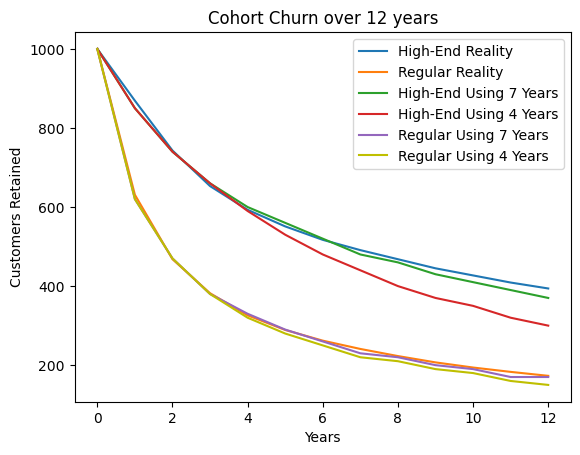

In [7]:
%matplotlib inline

#Using pyplot for our data visualization 
plt.plot(time,high_num_customers, label = 'High-End Reality')
plt.plot(time,reg_num_customers, label = 'Regular Reality')
plt.plot(time,h7_predictions, label = 'High-End Using 7 Years')
plt.plot(time,h4_predictions, label = 'High-End Using 4 Years')
plt.plot(time,r7_predictions, label = 'Regular Using 7 Years')
plt.plot(time,r4_predictions, label = 'Regular Using 4 Years', color='y')
plt.xlabel('Years')
plt.ylabel('Customers Retained')
plt.title('Cohort Churn over 12 years')
plt.legend()

In [9]:
print(h7_predictions)
print(h4_predictions)
print(r7_predictions)
print(r4_predictions)

[1000, 850, 740, 660, 600, 560, 520, 480, 460, 430, 410, 390, 370]
[1000, 850, 740, 660, 590, 530, 480, 440, 400, 370, 350, 320, 300]
[1000, 620, 470, 380, 330, 290, 260, 230, 220, 200, 190, 170, 170]
[1000, 620, 470, 380, 320, 280, 250, 220, 210, 190, 180, 160, 150]
